In [1]:
import numpy as np

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16,3)
import pickle

In [4]:
with open('IDEA_NS.pkl','rb') as file:
    raw = pickle.load(file)

In [5]:
raw.head()

,date,open,high,low,close,volume,adjclose
0,2021-07-30,8.25,8.40,8.20,8.25,118879621.0,8.25
1,2021-07-29,8.35,8.60,8.15,8.25,208357478.0,8.25
2,2021-07-28,8.45,8.75,8.20,8.35,268614790.0,8.35
3,2021-07-27,8.30,8.50,8.30,8.40,141166507.0,8.40
4,2021-07-26,8.35,8.50,8.10,8.30,219484526.0,8.30


In [6]:
df = raw.set_index('date')
df.head()

,open,high,low,close,volume,adjclose
date,,,,,,
2021-07-30,8.25,8.40,8.20,8.25,118879621.0,8.25
2021-07-29,8.35,8.60,8.15,8.25,208357478.0,8.25
2021-07-28,8.45,8.75,8.20,8.35,268614790.0,8.35
2021-07-27,8.30,8.50,8.30,8.40,141166507.0,8.40
2021-07-26,8.35,8.50,8.10,8.30,219484526.0,8.30


In [7]:
df_dti = df.reindex(pd.date_range(df.index.min(), df.index.max()), fill_value=None)
df_dti.head()

,open,high,low,close,volume,adjclose
2020-07-30,8.25,8.50,7.95,8.0,293048882.0,8.0
2020-07-31,8.10,8.50,8.10,8.4,340455059.0,8.4
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-03,8.40,8.85,8.00,8.7,422266642.0,8.7


In [8]:
ts=df_dti[['close']]
ts.head()

,close
2020-07-30,8.0
2020-07-31,8.4
2020-08-01,NaN
2020-08-02,NaN
2020-08-03,8.7


<AxesSubplot:>

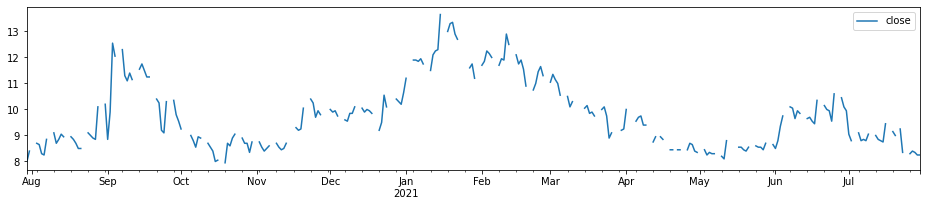

In [9]:
ts.plot()

## Fill empty dates with previous 14-day rolling mean

In [25]:
ts.close.fillna(ts.close.rolling(window=14, min_periods=2).mean(),inplace = True)

/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<AxesSubplot:>

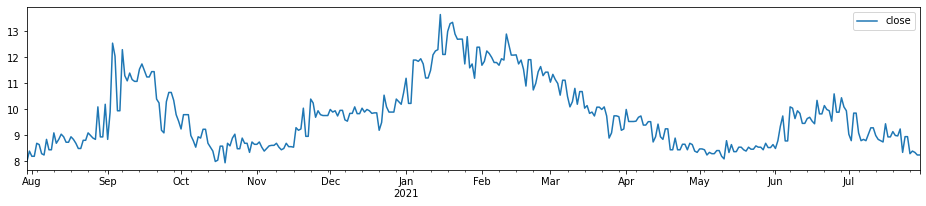

In [11]:
ts.plot()

## PACF and ACF for identifying PDQ factors

(<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>)

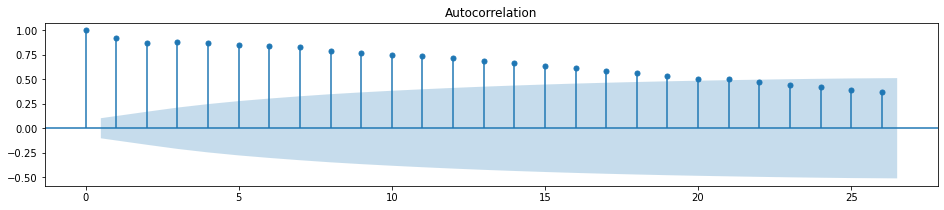

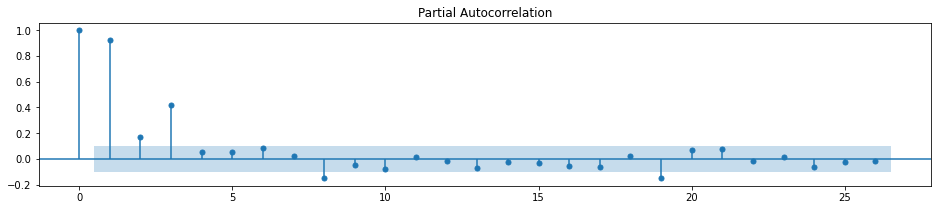

In [12]:
plot_acf(ts), plot_pacf(ts)

## Augmented Dickey-Fuller test to see if null-hypothesis is valid

(-1.8060483646696188,
 0.3774630100615394,
 8,
 357,
 {'1%': -3.44880082033912,
  '5%': -2.869670179576637,
  '10%': -2.5711012838861036},
 412.34107614037794)

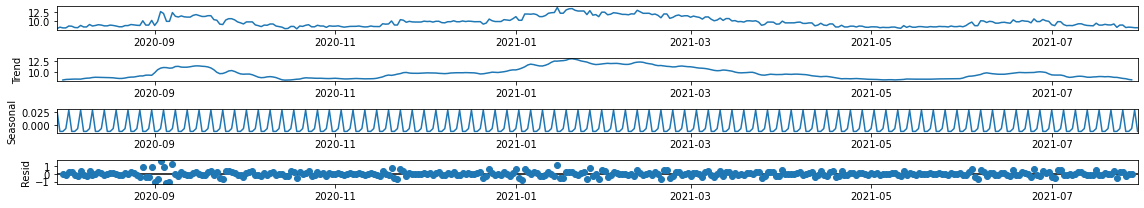

In [14]:
_ = seasonal_decompose(ts,period =4).plot()
adfuller(ts)

## Null hypothesis is valid since p = 0.38>0.05 ie, non-stationary timeseries
(as evident from the run-sequence plot)
## Hence doing first order differencing to convert to Stationary

<AxesSubplot:>

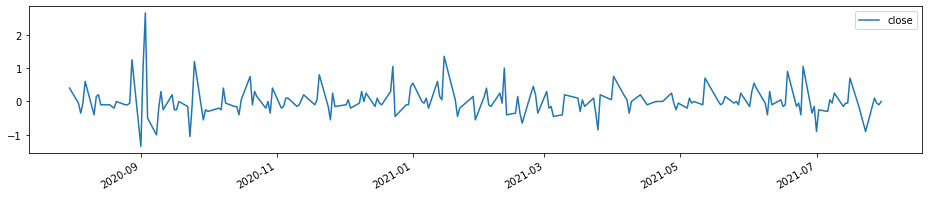

In [11]:
ts.diff(1).dropna().plot()

(<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>)

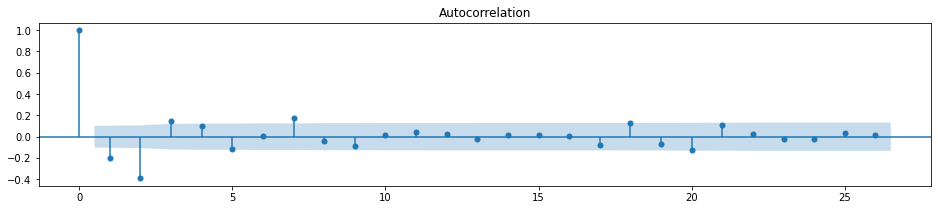

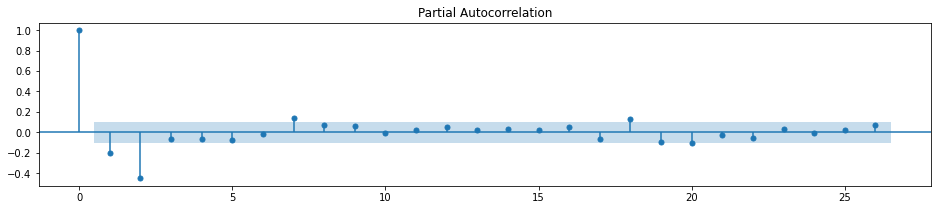

In [13]:
plot_acf(ts.diff(1).dropna()), plot_pacf(ts.diff(1).dropna())

(-7.571134159741112,
 2.8393346949402494e-11,
 6,
 358,
 {'1%': -3.448748905151901,
  '5%': -2.8696473721448728,
  '10%': -2.5710891239349585},
 413.10075968791864)

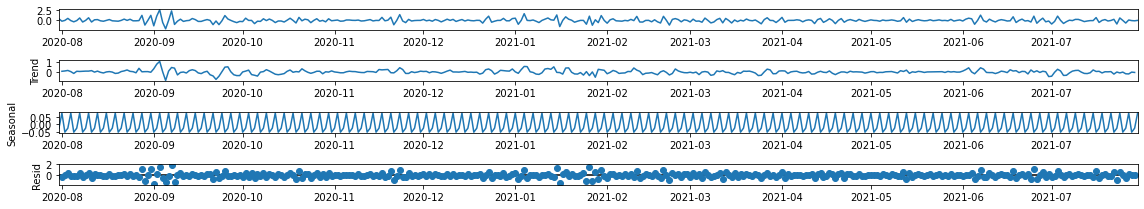

In [20]:
_ = seasonal_decompose(ts.diff(1).dropna(),period =3).plot()
adfuller(ts.diff(1).dropna())

## Initial ARIMA guesses (2,1,2)

In [26]:
# train test split
train, test = train_test_split(ts, shuffle = False, test_size=0.3)

In [27]:
order = (2, 1, 2)
arima212 = ARIMA(endog=train, order=order).fit()

/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


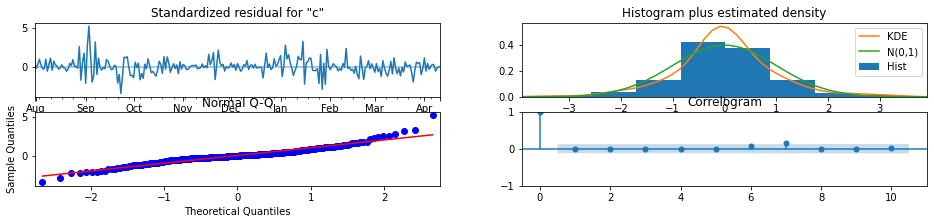

In [28]:
_ = arima212.plot_diagnostics()

## Defining MAPE and other error metrics

In [29]:
def mape(fc, act):
    fc = fc.values
    act = act.values.reshape(1,-1)
    return (abs(fc - act)/abs(act)).mean()*100

def plot_fc_vs_act(fc, act):
    _ = plt.plot(fc)
    _ = plt.plot(act)
    plt.legend(['FC', 'Act'])

8.201947662344033


/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


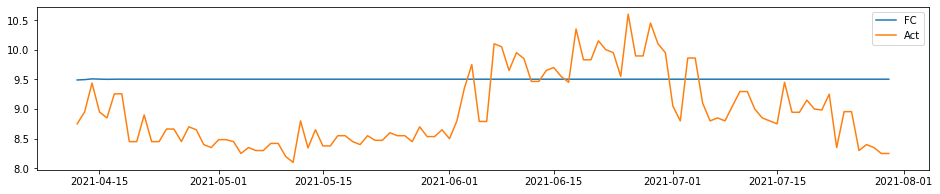

In [30]:
pred = arima212.predict(start = test.index[0], end = test.index[-1])

print(mape(pred, test))
plot_fc_vs_act(pred, test)

In [34]:
def plot_model(model, train):
    _ = plt.plot(train)
    _ = plt.plot(model.predict(start=train.index[0], end=train.index[-1]))
    _ = plt.plot(model.predict(start=test.index[0], end=test.index[-1]))
    plt.legend(['Data', 'Fit','Predict'])

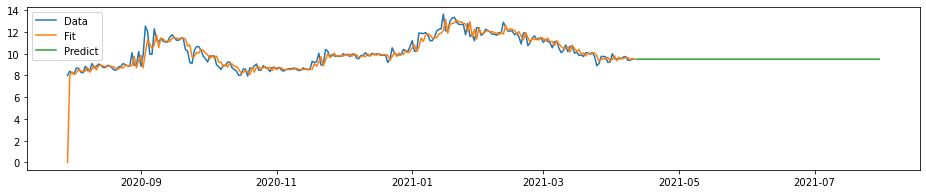

In [35]:
plot_model(arima212, train)

In [36]:
# function create model, return rmse
def runARIMA(order, train, test):
    model = ARIMA(endog=train, order=order).fit()
    pred = model.predict(start = test.index[0], end = test.index[-1])
    return mape(pred, test)

In [37]:
mapes=dict()
for p in range(0,5):
    for q in range(0,5):
        mapes[str(p) + '-1-' + str(q)] = (runARIMA((p,1,q), train, test))

/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

In [38]:
mapes = pd.Series(mapes)

In [39]:
mapes[mapes.values==mapes.min()]

3-1-4    8.071056
dtype: float64

/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


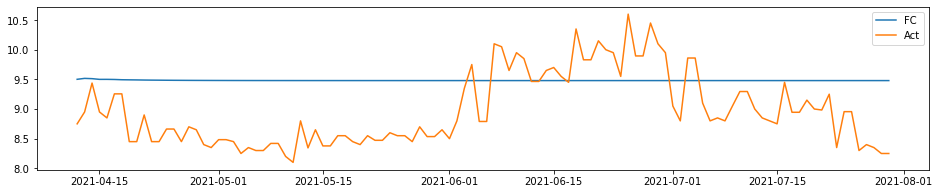

In [117]:
bestarima = ARIMA(endog=train, order=(3,1,4)).fit()
plot_fc_vs_act(bestarima.predict(start=test.index[0], end=test.index[-1]), test)

In [121]:
bestarima.params

ar.L1     0.371234
ar.L2     0.042984
ar.L3     0.314381
ma.L1    -0.700861
ma.L2    -0.329841
ma.L3     0.004273
ma.L4     0.219239
sigma2    0.210429
dtype: float64

In [162]:
sarimax_init=SARIMAX(endog=train, order=(3,1,4),seasonal_order=(3,1,4,30)).fit(disp=0)

/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [164]:
pred = sarimax_init.predict(start=test.index[0], end=test.index[-1])
print(mape(pred, test))

8.471521861867043


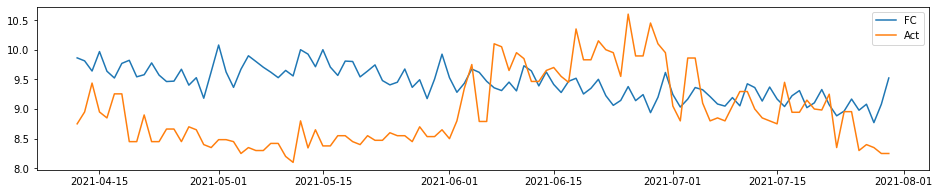

In [165]:
plot_fc_vs_act(pred, test)

/Users/nareshmadhur/miniforge3/envs/BasicML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


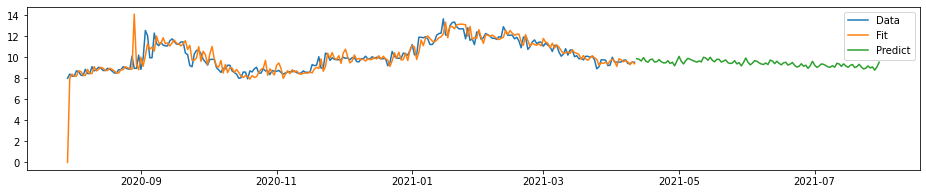

In [166]:
plot_model(sarimax_init, train)

In [168]:
from pyramid.arima import auto_arima

ModuleNotFoundError: No module named 'pyramid.arima'